Needed Imports

In [1]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt
import os

import albumentations as alb

## 4. Augmentation of the images and labels using Albumentations

In [2]:
# Checking image shape
random_img = cv2.imread(os.path.join('data', 'faces', 'train_faces', 'images', '2a01f440-90ed-11ed-af3e-74e5f916a70f.jpg'))
random_img.shape # at this moment all the images have a height of 480 pixels and a width of 640 pixels

(480, 640, 3)

4.1 Setting up albumentations transform pipeline

In [3]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
            alb.HorizontalFlip(p=0.5),
            alb.RandomBrightnessContrast(p=0.2),
            alb.RandomGamma(p=0.2),
            alb.RGBShift(p=0.2),
            alb.VerticalFlip(p=0.5)],

bbox_params = alb.BboxParams(format='albumentations', label_fields=['class_labels']))

4.2 Loading in test image and annotation with opencv and JSON

In [4]:
random_img

array([[[ 27,  14,   0],
        [ 28,  15,   0],
        [ 32,  17,   1],
        ...,
        [255, 254, 253],
        [255, 252, 247],
        [255, 252, 245]],

       [[ 26,  13,   0],
        [ 28,  15,   0],
        [ 32,  17,   1],
        ...,
        [255, 253, 255],
        [238, 229, 232],
        [157, 146, 149]],

       [[ 27,  14,   0],
        [ 29,  16,   0],
        [ 33,  18,   2],
        ...,
        [174, 160, 178],
        [ 96,  80, 103],
        [ 84,  68,  92]],

       ...,

       [[ 46,  69, 178],
        [ 41,  67, 175],
        [ 45,  68, 177],
        ...,
        [ 44,  45,  79],
        [ 46,  47,  91],
        [ 42,  44,  92]],

       [[ 41,  63, 169],
        [ 40,  64, 170],
        [ 42,  64, 170],
        ...,
        [ 41,  43,  77],
        [ 41,  44,  88],
        [ 38,  42,  90]],

       [[ 38,  60, 165],
        [ 40,  62, 167],
        [ 40,  62, 167],
        ...,
        [ 40,  42,  76],
        [ 39,  42,  86],
        [ 36,  40,  88]]

In [5]:
# Loading in the label dictionary of the random image
with open(os.path.join('data', 'faces', 'train_faces', 'labels', '2a01f440-90ed-11ed-af3e-74e5f916a70f.json'), 'r') as f:
    label = json.load(f)

# Now we can look into the dictionary
label['shapes'][0]['points']

[[223.71287128712873, 144.45544554455446],
 [431.63366336633663, 430.5940594059406]]

4.3 Extracting coordinates and rescale to match image resolution

In [6]:
# Putting coordinates in an array
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [7]:
# [x_min, y_min, x_max, y_max]
coords

[223.71287128712873, 144.45544554455446, 431.63366336633663, 430.5940594059406]

In [8]:
# Change coordinates from pascal_voc to albumentation values by dividing it with the original width and height
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [9]:
# Now we have coords in albumentations format
coords

[0.3495513613861386, 0.3009488448844885, 0.674427599009901, 0.8970709570957095]

4.4 Apply augmentations

In [10]:
# Using augmentor to augment image
augmented = augmentor(image=random_img, bboxes=[coords], class_labels=['faces'])

In [11]:
# Checking some things on augmented image
# [x_min, y_min, x_max, y_max]
augmented['bboxes']

[(0.4704730473047305,
  0.06090209020902093,
  0.9325192519251925,
  0.6967656765676568)]

In [12]:
# [x_min, y_min]
augmented['bboxes'][0][:2]

(0.4704730473047305, 0.06090209020902093)

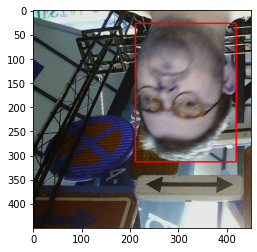

In [13]:
cv2.rectangle(augmented['image'],
            tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)), # top most coordinate (first two values)
            tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)), # bottom most coordinate (last two values)
            (255,0,0), 2)

plt.imshow(augmented['image']) # after the transformation we see that the bounding box is still around the face   

We did the augmentation for one image now, let's create a pipeline to run the augmentation for every image in train, test and val.

## 5. Build and run augmentation pipeline

5.1 Run augmentation pipeline

In [15]:
for partition in ['train_faces', 'test_faces', 'val_faces']:
    for image in os.listdir(os.path.join('data', 'faces', partition, 'images')):
        img = cv2.imread(os.path.join('data', 'faces', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', 'faces', partition, 'labels', f'{image.split(".")[0]}.json')

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))
        
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['faces'])
                cv2.imwrite(os.path.join('aug_data', 'faces', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', 'faces', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)    
                    
        
        except Exception as e:
            print(e)
            

x_max is less than or equal to x_min for bbox [0.7347617574257426, 0.8485973597359736, 0.4013768564356435, 0.2782590759075908, 'faces'].
x_max is less than or equal to x_min for bbox [0.18169863861386137, 0.7702145214521452, 0.0006961633663365996, 0.3989273927392739, 'faces'].
x_max is less than or equal to x_min for bbox [0.2536355198019802, 0.6825495049504952, 0.00301670792079205, 0.3061056105610562, 'faces'].
x_max is less than or equal to x_min for bbox [0.7185179455445544, 0.8351897689768978, 0.3990563118811881, 0.299917491749175, 'faces'].
x_max is less than or equal to x_min for bbox [0.997756806930693, 0.5587871287128714, 0.8391862623762376, 0.1978135313531353, 'faces'].
x_max is less than or equal to x_min for bbox [0.6666924504950494, 0.4102722772277228, 0.42690284653465344, 0.01732673267326734, 'faces'].
x_max is less than or equal to x_min for bbox [0.6605043316831682, 0.3989273927392739, 0.38203898514851486, 0.004950495049504963, 'faces'].
x_max is less than or equal to x_